In [2]:
import cv2
import os
import skimage
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

import utils
import orb

In [3]:
def orb_match(src, tar):
    detector = cv2.ORB_create(10000)
    kpts1 = detector.detect(src, None)
    kpts2 = detector.detect(tar, None)

    descriptor = cv2.xfeatures2d.BEBLID_create(0.75)

    kpts1, desc1 = descriptor.compute(src, kpts1)
    kpts2, desc2 = descriptor.compute(tar, kpts2)

#     matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    nn_matches = matcher.knnMatch(desc1, desc2, 2)

    return kpts1, kpts2, nn_matches

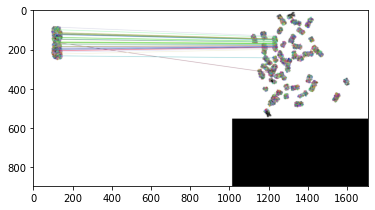

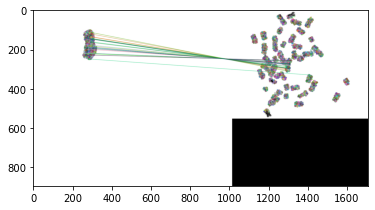

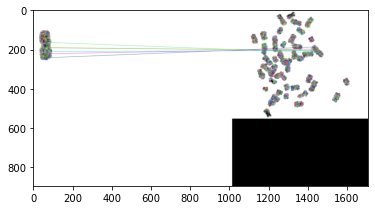

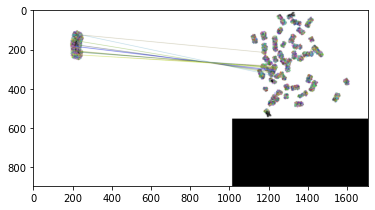

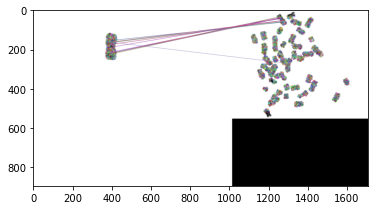

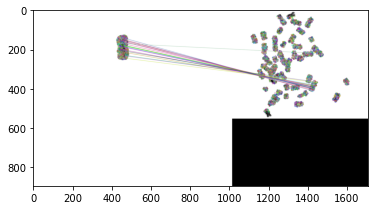

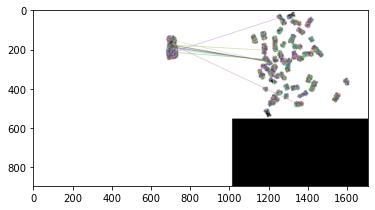

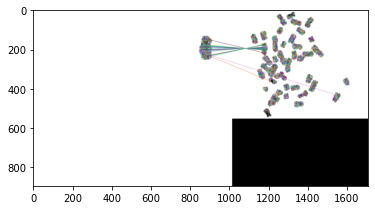

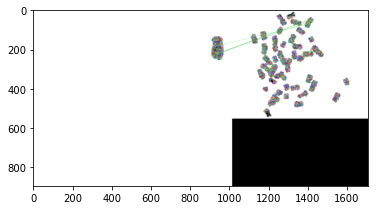

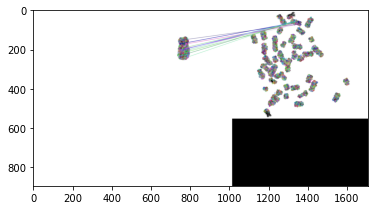

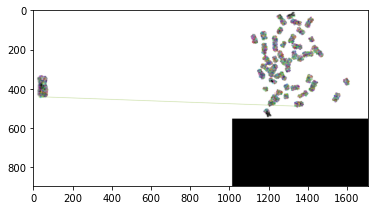

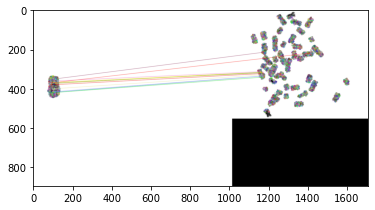

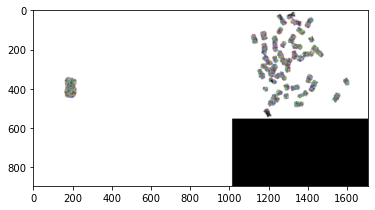

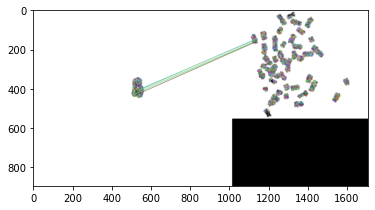

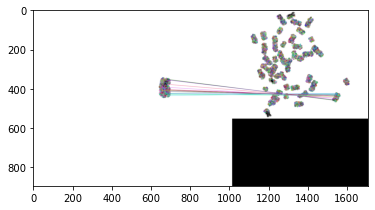

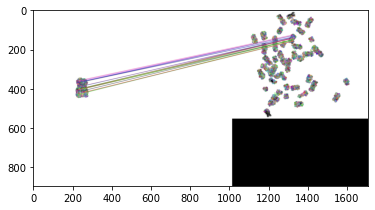

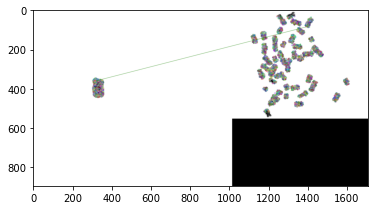

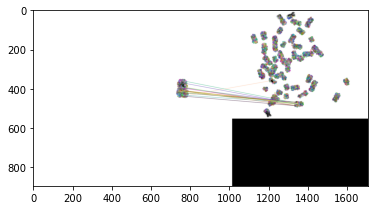

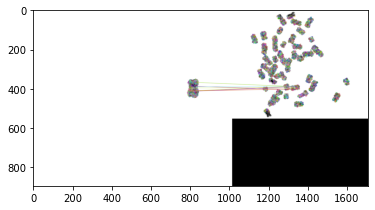

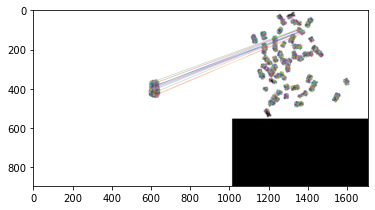

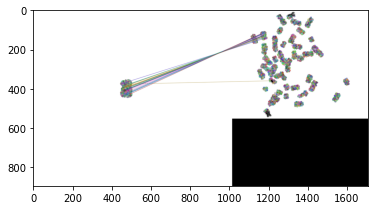

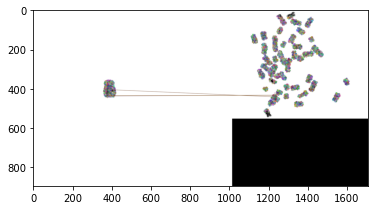

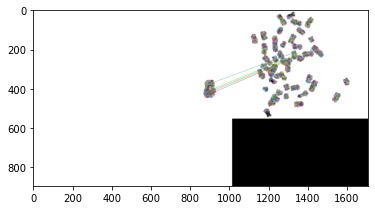

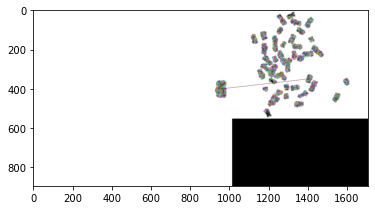

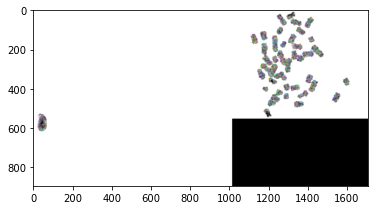

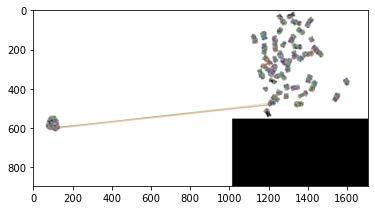

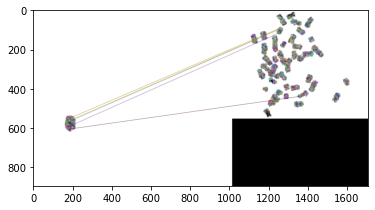

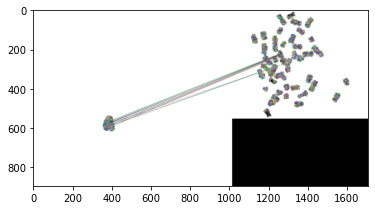

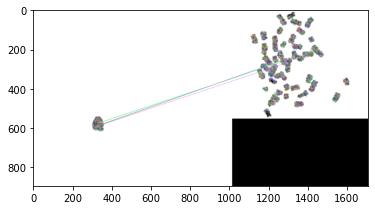

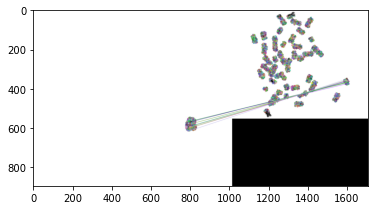

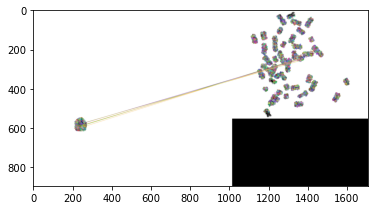

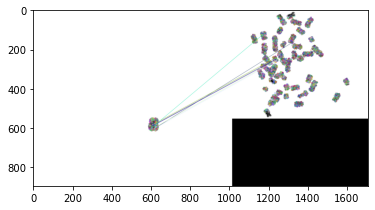

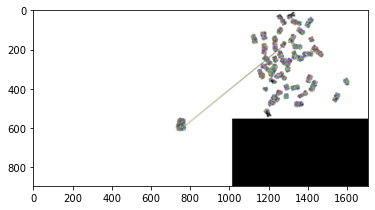

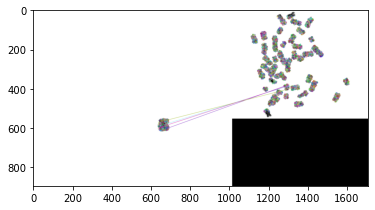

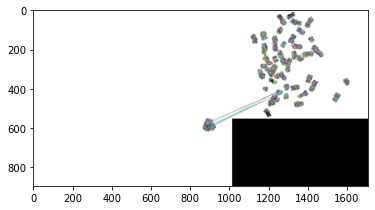

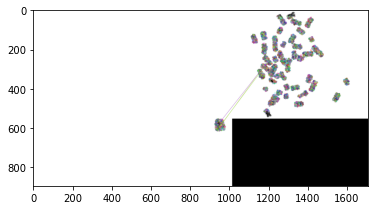

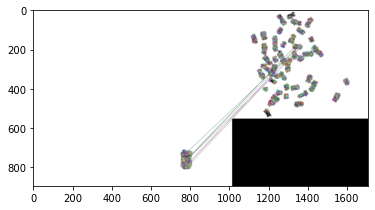

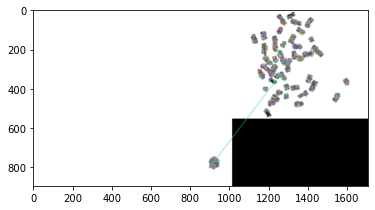

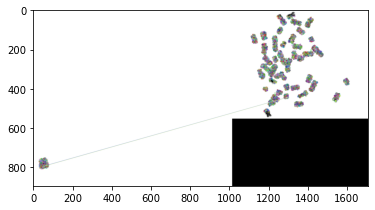

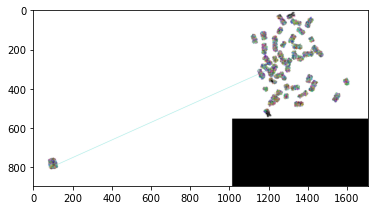

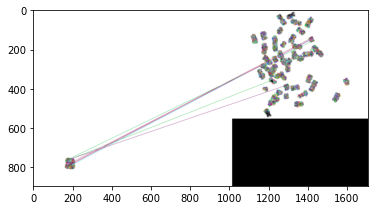

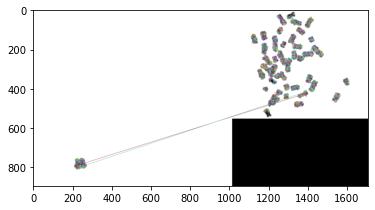

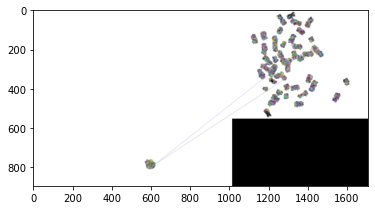

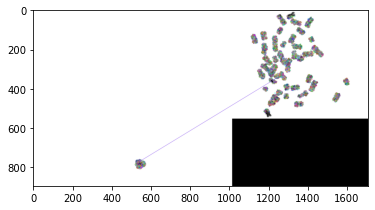

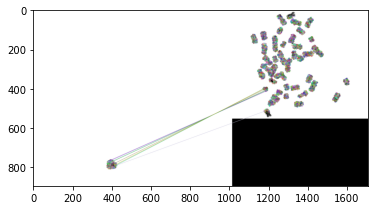

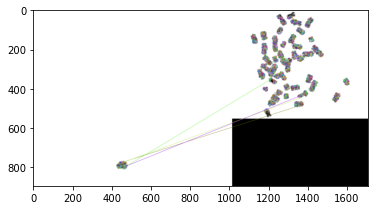

In [12]:
im_a_path = '/data1/huangkaibin/Data/karyotype/origin_split/a_crop/'
im_k_path = '/data1/huangkaibin/Data/karyotype/origin_split/k/'

im_a_name = sorted(list(os.listdir(im_a_path)))
im_k_name = sorted(list(os.listdir(im_k_path)))

k_erode = np.ones((5, 5), np.uint8)
k_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], np.float32)

for name in im_a_name[:1]:
    im_a = cv2.imread(os.path.join(im_a_path, name), 0)
    im_k = cv2.imread(os.path.join(im_k_path, name.replace('A.TIF', 'K.TIF')), 0)
    
    im_a = cv2.filter2D(im_a, -1, k_sharpen)
    mask_k = utils.threshold_segm(im_k, 250)
    
    
    
    for prop in regionprops(label(mask_k)):
#         sub_im_k = im_k[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]]
#         sub_mask_k = mask_k[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]]
        sub_im_k = utils.show_spec_area(im_k, prop.bbox, 255)
        sub_im_k = cv2.filter2D(sub_im_k, -1, k_sharpen)
        sub_mask_k = utils.show_spec_area(mask_k, prop.bbox, 0)
        if sub_mask_k.sum()/255 > 200:
#             sub_mask_k = utils.fill_holes(sub_mask_k)
            kpts1, kpts2, nn_matches = orb_match(sub_im_k, im_a)
            
            good = []
            for m, n in nn_matches:
                if m.distance < 0.75 * n.distance:
                    good.append(m)
            match_draw = cv2.drawMatches(sub_im_k, kpts1, im_a, kpts2, good, None)
            plt.imshow(match_draw), plt.show()

In [14]:
def is_chromosome(mask, threshold=200):
    return mask.sum()/mask.max() > 200

def get_bbox(mask):
    pos = np.where(mask)
    xmin = np.min(pos[0])
    xmax = np.max(pos[0])
    ymin = np.min(pos[1])
    ymax = np.max(pos[1])
    return xmin, ymin, xmax, ymax

def sub_chromosome_generator(img):
    k_s = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], np.float32) # sharpen kernel
    k_e = np.ones((5, 5), np.uint8)                                        # erode kernel
    msk = utils.threshold_segm(img, 250)
    for prop in regionprops(label(msk)):
        sub_img = utils.show_spec_area(img, prop.bbox, 255)
        sub_msk = utils.show_spec_area(msk, prop.bbox, 0)

#         sub_img = cv2.filter2D(sub_img, -1, k_s)
        sub_msk = utils.fill_holes(sub_msk)
        if is_chromosome(sub_msk):
            sub_msk_erode = cv2.erode(sub_msk, k_e)
            
            labels = label(sub_msk_erode)
            props  = regionprops(labels)
            
            if len(props) > 1:
                obj_ids = np.unique(labels)
                obj_ids = obj_ids[1:]
                labels = labels == obj_ids[:, None, None]
                
                for ssub_msk in labels:
                    ssub_msk = cv2.dilate(255*ssub_msk.astype(np.uint8), k_e)
#                     xmin, xmax, ymin, ymax = get_bbox(ssub_msk)
                    if is_chromosome(ssub_msk):
                        bbox = get_bbox(ssub_msk)
                        ssub_img = utils.show_spec_area(sub_img, bbox, 255)
                        yield ssub_img, ssub_msk
            else:
                yield sub_img, sub_msk
                
# def get_sub_chromosome(src, dst, src_msk):
def get_sub_chromosome(src_img, src_msk, dst_img):

    # src: image_k
    # dst: image_a
    # return: bbox
    k_s = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], np.float32) # sharpen kernel
    k_e = np.ones((5, 5), np.uint8)                                        # erode kernel
#     msk = utils.threshold_segm(img, 250)
#     msk = utils.fill_holes(msk)
#     plt.imshow(msk), plt.show()
#     exit()
    for prop in regionprops(label(src_msk)):
        sub_src_img = utils.show_spec_area(src_img, prop.bbox, 255)
        sub_src_msk = utils.show_spec_area(src_msk, prop.bbox, 0)

        if is_chromosome(sub_src_msk):
            esub_src_msk = cv2.erode(sub_src_msk, k_e)
            
            ssub_src_msks = label(esub_src_msk)
            props = regionprops(ssub_src_msks)
            
            if len(props) > 1:
                obj_ids = np.unique(ssub_src_msks)
                obj_ids = obj_ids[1:]
                ssub_src_msks = ssub_src_msks == obj_ids[:, None, None]
                
                for ssub_src_msk in ssub_src_msks:
                    ssub_src_msk = cv2.dilate(255*ssub_src_msk.astype(np.uint8), k_e)
#                     xmin, xmax, ymin, ymax = get_bbox(ssub_msk)
                    if is_chromosome(ssub_src_msk):
                        yield orb_match(ssub_src_msk, dst_img)
            else:
                yield orb_match(sub_src_img, dst_img)
                

In [13]:
im_a_path = '/data1/huangkaibin/Data/karyotype/origin_split/a_crop/'
im_k_path = '/data1/huangkaibin/Data/karyotype/origin_split/k/'

im_a_name = sorted(list(os.listdir(im_a_path)))
im_k_name = sorted(list(os.listdir(im_k_path)))

# k_erode = np.ones((5, 5), np.uint8)
k_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], np.float32)

for name in im_a_name[1:2]:
    im_a = cv2.imread(os.path.join(im_a_path, name), 0)
    im_k = cv2.imread(os.path.join(im_k_path, name.replace('A.TIF', 'K.TIF')), 0)
    
    im_a = cv2.filter2D(im_a, -1, k_sharpen)
    for sub_img, sub_msk in sub_chromosome_generator(im_k):
#         _, axis = plt.subplots(1, 2)
#         axis[0].imshow(sub_img)
#         axis[1].imshow(sub_msk)
#         plt.show()
        kpts1, kpts2, nn_matches = orb_match(sub_img, im_a)
        good = []
        for m, n in nn_matches:
            if m.distance < 0.95 * n.distance:
                good.append(m)
        
        matches_mask = []
        if len(good) >= 4:
            src_pts = np.float32([kpts1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kpts2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            
            M, ransac_mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)
            matches_mask = ransac_mask.ravel().tolist()
            

#         match_draw = cv2.drawMatches(sub_img, kpts1, im_a, kpts2, good, None)
#         plt.imshow(match_draw), plt.show()

42
102
51
15
62
80
133
40
44
49
76
9
102
40
27
103
76
64
85
8
34
41
62
48
97
82
10
28
46
16
21
34
13
13
35
10
28
6
35
27
43
3
5
21
11
10


In [20]:
dst_path = '/data1/huangkaibin/Data/karyotype/origin_split/a_crop/'
src_path = '/data1/huangkaibin/Data/karyotype/origin_split/k/'

dst_names = sorted(list(os.listdir(dst_path)))
src_names = sorted(list(os.listdir(src_path)))

# k_erode = np.ones((5, 5), np.uint8)
k_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], np.float32)

for name in src_names[1:2]:
    src_img = cv2.imread(os.path.join(src_path, name), 0)
    dst_img = cv2.imread(os.path.join(dst_path, name.replace('K.TIF', 'A.TIF')), 0)
    
    dst_img = cv2.filter2D(dst_img, -1, k_sharpen)
    src_msk = utils.threshold_segm(src_img, 250)
    
    match_infos = [info for info in get_sub_chromosome(src_img, src_msk, dst_img)]
    match_infos.sort(key=lambda x: -len(x[2]))

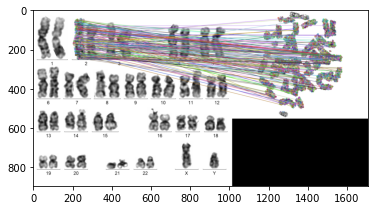

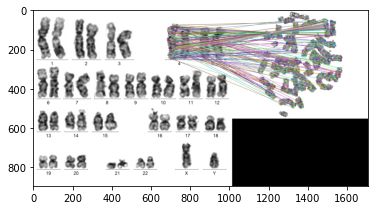

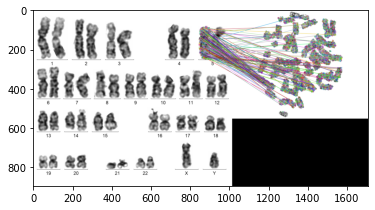

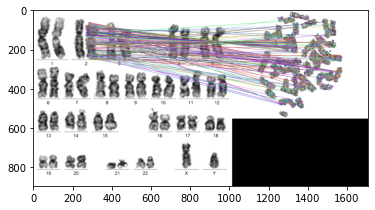

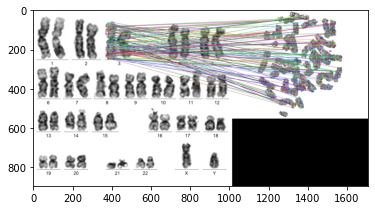

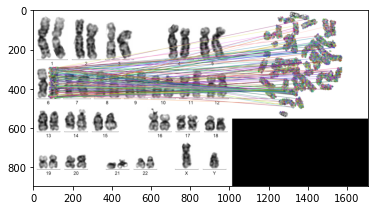

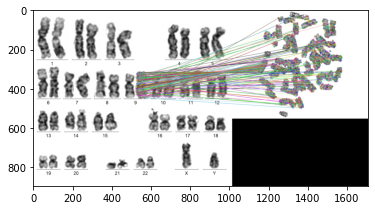

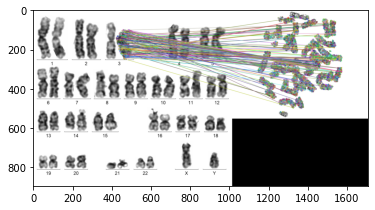

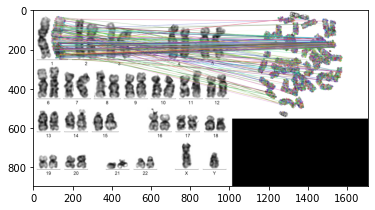

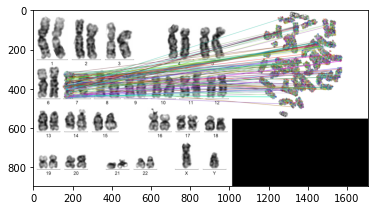

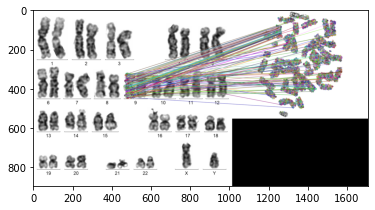

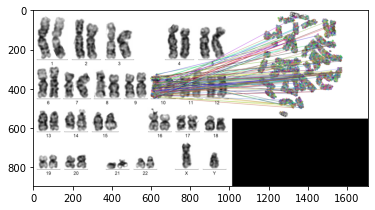

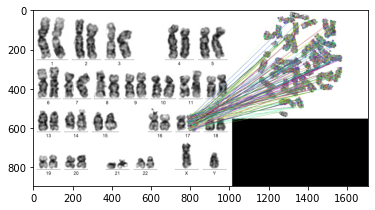

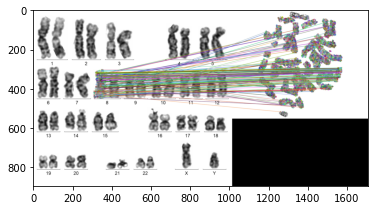

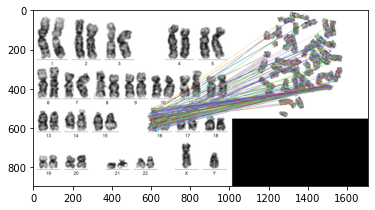

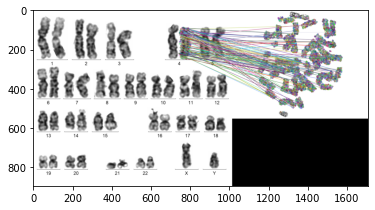

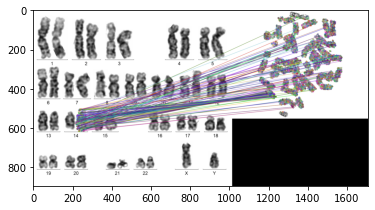

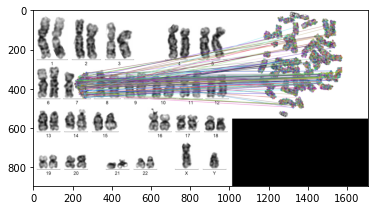

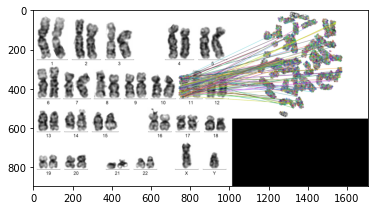

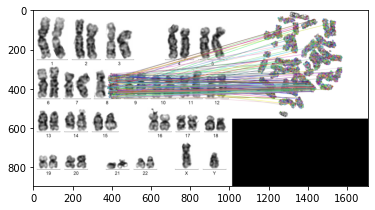

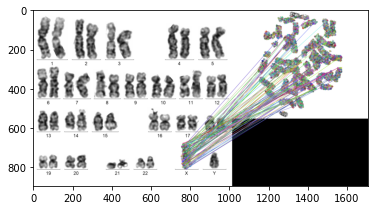

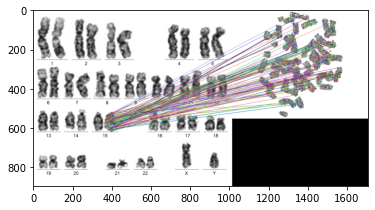

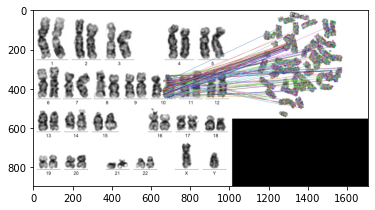

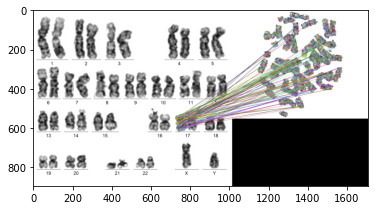

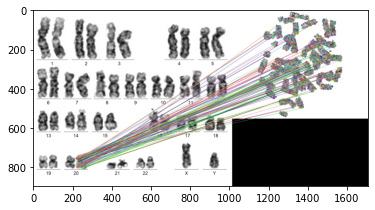

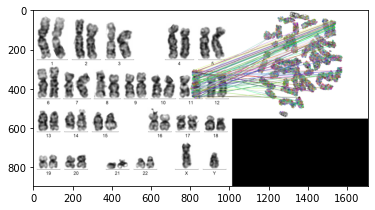

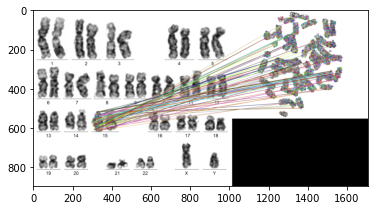

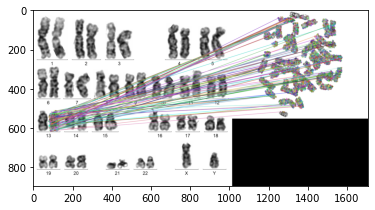

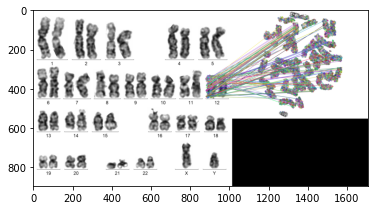

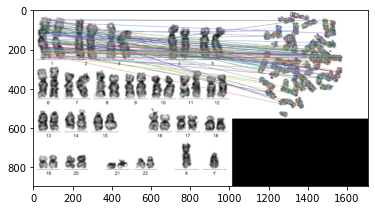

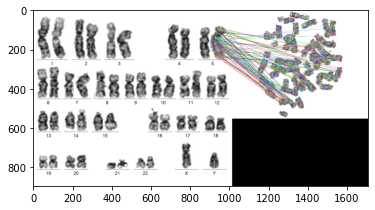

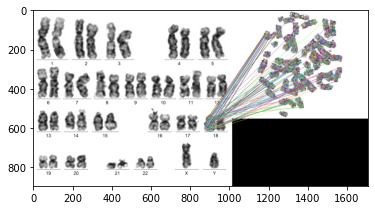

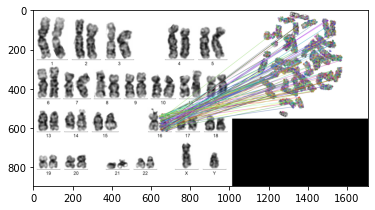

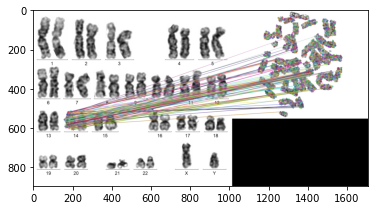

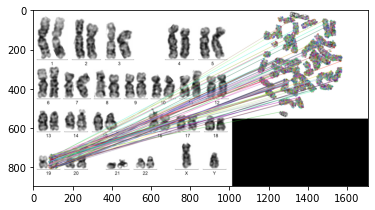

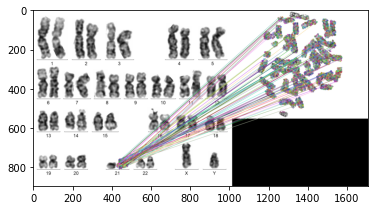

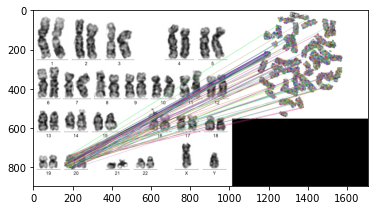

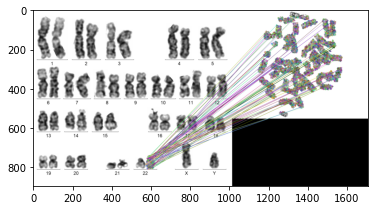

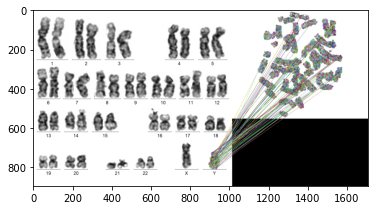

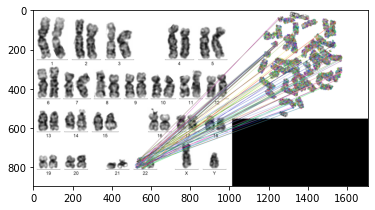

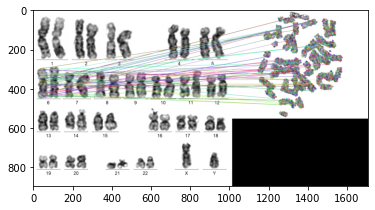

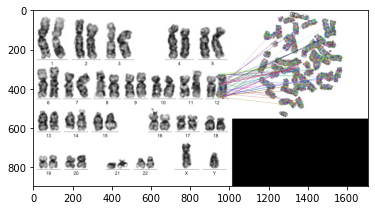

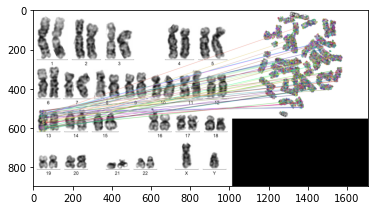

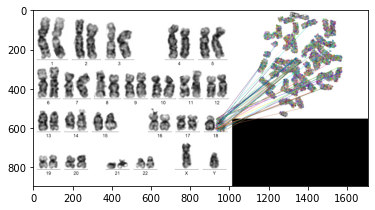

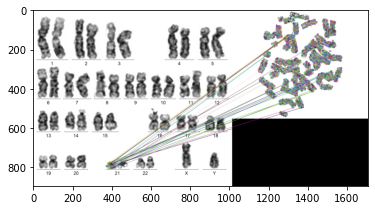

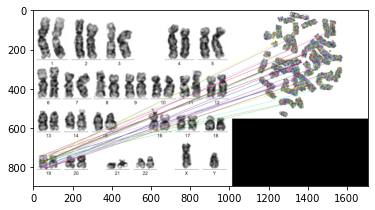

In [21]:
for kpts1, kpts2, nn_matches in match_infos:
    good = []
    for m, n in nn_matches:
        if m.distance < 0.95 * n.distance:
            good.append(m)

    matches_mask = []
    if len(good) >= 4:
        src_pts = np.float32([kpts1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kpts2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        M, ransac_mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)
        matches_mask = ransac_mask.ravel().tolist()

        match_draw = cv2.drawMatches(src_img, kpts1, dst_img, kpts2, good, None)
        plt.imshow(match_draw), plt.show()